In [1]:
import pandas as pd
import numpy as np
from annoy import AnnoyIndex


from src.model import get_embeddings

/Users/dabetm/dev/contests/dataverse-2024/datathon_recommender_system/.venv/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/Users/dabetm/dev/contests/dataverse-2024/datathon_recommender_system/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/dabetm/dev/contests/dataverse-2024/datathon_recommender_system/.venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warni

### Read dataset

In [3]:
dataset_path = "assets/all_data_sets_together_fixed.parquet"

raw_data = pd.read_parquet(dataset_path, engine="pyarrow")

print(raw_data.shape)
raw_data.head()

(44424, 34)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,...,discountedPrice,brandName,description,myntraRating,vat,materials_care_desc,colour1,visualTag,variantName,articleNumber
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,...,1195.0,Turtle,"<p style=""text-align: justify;""><strong>Compos...",1,5.5,None,White,,Check,73223-00
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,...,1499.0,Peter England,<p><strong>Style Note</strong><br /> Look cool...,0,5.5,None,,,Peter England Party Jeans,EDM3123686
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,...,6500.0,Titan,<p>Silver steel case with a fixed bezel for du...,0,14.5,<p>NA</p>,White,,Titan Watches,NB9796SM01
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,...,1699.0,Manchester United,<p>Composition<br /> Black Official Merchandis...,1,5.5,None,NA,,Solid,1NZ00101
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,...,1099.0,Puma,<p>Grey knit polo T-shirt with moisture manage...,1,5.5,<p>100% polyester<br />Machine wash cold<br />...,NA,,T-shirt,50802202


In [4]:
raw_data.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName',
       'filename', 'link', 'colour2', 'styleType', 'productTypeId',
       'articleAttributes', 'price', 'fashionType', 'navigationId',
       'catalogAddDate', 'style_note', 'ageGroup', 'weight', 'size_fit_desc',
       'discountedPrice', 'brandName', 'description', 'myntraRating', 'vat',
       'materials_care_desc', 'colour1', 'visualTag', 'variantName',
       'articleNumber'],
      dtype='object')

### Clean dataset


In [34]:
columns_to_ignore = {
    # "id",
    "filename",
    "link",
    "productTypeId",
    "navigationId",
    "prince", # since the final price is the relevant one while searching
    "catalogAddDate",
    "vat",
    "articleNumber",
}

columns_to_consider = set(raw_data.columns) - columns_to_ignore
columns_to_consider

{'ageGroup',
 'articleAttributes',
 'articleType',
 'baseColour',
 'brandName',
 'colour1',
 'colour2',
 'description',
 'discountedPrice',
 'fashionType',
 'gender',
 'id',
 'masterCategory',
 'materials_care_desc',
 'myntraRating',
 'price',
 'productDisplayName',
 'season',
 'size_fit_desc',
 'styleType',
 'style_note',
 'subCategory',
 'usage',
 'variantName',
 'visualTag',
 'weight',
 'year'}

`description` and `materials_care_desc` columns have HTML code, we can try to remplace some tags with spaces

In [35]:
data = raw_data.copy()

data.reset_index(inplace=True)
data = data[list(columns_to_consider)]

data

,styleType,discountedPrice,myntraRating,colour2,materials_care_desc,variantName,articleAttributes,style_note,productDisplayName,subCategory,...,gender,visualTag,masterCategory,year,weight,brandName,ageGroup,articleType,id,fashionType
0,P,1195.0,1,NA,None,Check,Slim Fit Checked Garment Measurements in Long ...,None,Turtle Check Men Navy Blue Shirt,Topwear,...,Men,,Apparel,2011.0,0,Turtle,Adults-Men,Shirts,15970,Fashion
1,P,1499.0,0,,None,Peter England Party Jeans,Slim Fit To-Fit Denotes Body Measurements in L...,None,Peter England Men Party Blue Jeans,Bottomwear,...,Men,,Apparel,2012.0,0,Peter England,Adults-Men,Jeans,39386,Fashion
2,P,6500.0,0,NA,<p>NA</p>,Titan Watches,Synthetic Hybrid Automatic 50 m Round Battery ...,"<p>This stylish watch from Titan, with classic...",Titan Women Silver Watch,Watches,...,Women,,Accessories,2016.0,0,Titan,Adults-Women,Watches,59263,Fashion
3,P,1699.0,1,NA,None,Solid,Blended To-Fit Denotes Body Measurements in,None,Manchester United Men Solid Black Track Pants,Bottomwear,...,Men,,Apparel,2011.0,0,Manchester United,Adults-Men,Track Pants,21379,Fashion
4,P,1099.0,1,NA,<p>100% polyester<br />Machine wash cold<br />...,T-shirt,Solid Garment Measurements in Short Sleeves Ca...,"<p>With its classic styling and muted colour, ...",Puma Men Grey T-shirt,Topwear,...,Men,,Apparel,2012.0,0,Puma,Adults-Men,Tshirts,53759,Fashion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44419,RTV,3000.0,0,,None,Caddy,Sneakers,None,Gas Men Caddy Casual Shoe,Shoes,...,Men,,Footwear,2013.0,0,GAS,Adults-Men,Casual Shoes,17036,Fashion
44420,P,499.0,1,NA,None,SOCCER TRACK,,None,Lotto Men's Soccer Track Flip Flop,Flip Flops,...,Men,,Footwear,2011.0,0,Lotto,Adults-Men,Flip Flops,6461,Fashion
44421,P,799.0,0,,None,Graphic,Regular Fit Printed Garment Measurements in Sh...,None,Puma Men Graphic Stellar Blue Tshirt,Topwear,...,Men,,Apparel,2011.0,0,Puma,Adults-Men,Tshirts,18842,Fashion
44422,RTV,850.0,0,NA,<p>NA</p>,BLUE LADY PART 2,,<p>NA</p>,Rasasi Women Blue Lady Perfume,Fragrance,...,Women,,Personal Care,2017.0,0,Rasasi,Adults-Women,Perfume and Body Mist,46694,Core


In [36]:
data.columns

Index(['styleType', 'discountedPrice', 'myntraRating', 'colour2',
       'materials_care_desc', 'variantName', 'articleAttributes', 'style_note',
       'productDisplayName', 'subCategory', 'size_fit_desc', 'season',
       'description', 'baseColour', 'usage', 'colour1', 'price', 'gender',
       'visualTag', 'masterCategory', 'year', 'weight', 'brandName',
       'ageGroup', 'articleType', 'id', 'fashionType'],
      dtype='object')

In [37]:
data.iloc[0]["description"]

'<p style="text-align: justify;"><strong>Composition</strong><br />Dark brown and indigo blue plaid check shirt with white accents, made of 100% cotton, has long sleeves with buttoned cuffs and a button on the elbow for rolling up the sleeve, denim spread collar, buttoned front placket, patch pocket on the upper left chest and a curved hemline<br /><br /><strong>Fitting</strong><br />Slim<br /><br /><strong>Wash care</strong><br />Machine wash cold at 30 degrees with like colours<br />Do not bleach <br />Wash and dry inside out<br />Hang to dry in shade<br />Medium iron<br /><br />The cleverly mitired pocket on the upper left chest and denim collar adds smooth styling to this dark brown and indigo blue plaid check shirt from turtle, while the cotton fabric keeps you feeling fresh and comfortable all day. Part of the proceeds from the sale of this product go towards the Save Turtle project in collaboration with WWF and Wildlife Society of Orissa, making it an environment friendly choice

In [38]:
import re

def remove_html_tags(text):
    clean = re.sub(r'<.*?>', ' ', str(text))

    return clean

In [39]:
data["description"] = data["description"].apply(remove_html_tags)

#remove_html_tags(data.iloc[0]["description"])
data.iloc[0]["description"]

'  Composition  Dark brown and indigo blue plaid check shirt with white accents, made of 100% cotton, has long sleeves with buttoned cuffs and a button on the elbow for rolling up the sleeve, denim spread collar, buttoned front placket, patch pocket on the upper left chest and a curved hemline   Fitting  Slim   Wash care  Machine wash cold at 30 degrees with like colours Do not bleach  Wash and dry inside out Hang to dry in shade Medium iron  The cleverly mitired pocket on the upper left chest and denim collar adds smooth styling to this dark brown and indigo blue plaid check shirt from turtle, while the cotton fabric keeps you feeling fresh and comfortable all day. Part of the proceeds from the sale of this product go towards the Save Turtle project in collaboration with WWF and Wildlife Society of Orissa, making it an environment friendly choice. Team this with chinos or jeans and sneakers.   Model statistics  Product is a size M on a model of height 6\' and chest 39" '

In [40]:
data.iloc[2]["materials_care_desc"]

'<p>NA</p>'

In [41]:
data["materials_care_desc"] = data["materials_care_desc"].apply(remove_html_tags)

data.iloc[0]["materials_care_desc"]

'None'

Cast year to int

In [42]:
data['year'] = pd.to_numeric(data['year'], errors='coerce')
data['year'].fillna(0, inplace=True)
data['year'] = data['year'].astype(int)
data["year"]

/var/folders/2p/3hjggzn502gcc84m1lyqtcc00000gn/T/ipykernel_9453/2459019162.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['year'].fillna(0, inplace=True)


0        2011
1        2012
2        2016
3        2011
4        2012
         ... 
44419    2013
44420    2011
44421    2011
44422    2017
44423    2016
Name: year, Length: 44424, dtype: int64

### Generate condensed descriptions

In [47]:
import math


def check_empty_value(val) -> bool:
    if not val:
        return False
    if val == "None" or val == "none" or val == " " or val == "null":
        return False
    if not isinstance(val, str) and (math.isnan(val) or pd.isna(val)):
        return False

    return True


def build_condensed_description_from_columns(df: pd.DataFrame, columns: list[str]) -> list[str]:
    string_list = []
    for index, row in df.iterrows():
        values = [str(row[column]) for column in columns if check_empty_value(row[column])]
        string = " ".join(values)
        string.strip()
        string_list.append(string)
    return string_list

In [48]:
columns_without_id = columns_to_consider.copy()
columns_without_id.remove("id")


data.loc[:, "condensed_description"] = build_condensed_description_from_columns(data, columns_without_id)

data

,styleType,discountedPrice,myntraRating,colour2,materials_care_desc,variantName,articleAttributes,style_note,productDisplayName,subCategory,...,visualTag,masterCategory,year,weight,brandName,ageGroup,articleType,id,fashionType,condensed_description
0,P,1195.0,1,NA,None,Check,Slim Fit Checked Garment Measurements in Long ...,None,Turtle Check Men Navy Blue Shirt,Topwear,...,,Apparel,2011,0,Turtle,Adults-Men,Shirts,15970,Fashion,1195.0 Men P 1195.0 1 Apparel 2011 NA Check Sl...
1,P,1499.0,0,,None,Peter England Party Jeans,Slim Fit To-Fit Denotes Body Measurements in L...,None,Peter England Men Party Blue Jeans,Bottomwear,...,,Apparel,2012,0,Peter England,Adults-Men,Jeans,39386,Fashion,1499.0 Men P 1499.0 Apparel 2012 Peter England...
2,P,6500.0,0,NA,NA,Titan Watches,Synthetic Hybrid Automatic 50 m Round Battery ...,"<p>This stylish watch from Titan, with classic...",Titan Women Silver Watch,Watches,...,,Accessories,2016,0,Titan,Adults-Women,Watches,59263,Fashion,6500.0 Women P 6500.0 Accessories 2016 NA NA ...
3,P,1699.0,1,NA,None,Solid,Blended To-Fit Denotes Body Measurements in,None,Manchester United Men Solid Black Track Pants,Bottomwear,...,,Apparel,2011,0,Manchester United,Adults-Men,Track Pants,21379,Fashion,1699.0 Men P 1699.0 1 Apparel 2011 NA Solid Bl...
4,P,1099.0,1,NA,100% polyester Machine wash cold Warm iron,T-shirt,Solid Garment Measurements in Short Sleeves Ca...,"<p>With its classic styling and muted colour, ...",Puma Men Grey T-shirt,Topwear,...,,Apparel,2012,0,Puma,Adults-Men,Tshirts,53759,Fashion,1099.0 Men P 1099.0 1 Apparel 2012 NA 100% po...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44419,RTV,3000.0,0,,None,Caddy,Sneakers,None,Gas Men Caddy Casual Shoe,Shoes,...,,Footwear,2013,0,GAS,Adults-Men,Casual Shoes,17036,Fashion,3000.0 Men RTV 3000.0 Footwear 2013 Caddy Snea...
44420,P,499.0,1,NA,None,SOCCER TRACK,,None,Lotto Men's Soccer Track Flip Flop,Flip Flops,...,,Footwear,2011,0,Lotto,Adults-Men,Flip Flops,6461,Fashion,499.0 Men P 499.0 1 Footwear 2011 NA SOCCER TR...
44421,P,799.0,0,,None,Graphic,Regular Fit Printed Garment Measurements in Sh...,None,Puma Men Graphic Stellar Blue Tshirt,Topwear,...,,Apparel,2011,0,Puma,Adults-Men,Tshirts,18842,Fashion,799.0 Men P 799.0 Apparel 2011 Graphic Regular...
44422,RTV,850.0,0,NA,NA,BLUE LADY PART 2,,<p>NA</p>,Rasasi Women Blue Lady Perfume,Fragrance,...,,Personal Care,2017,0,Rasasi,Adults-Women,Perfume and Body Mist,46694,Core,850.0 Women RTV 850.0 Personal Care 2017 NA N...


In [49]:
data.iloc[0]["condensed_description"]

'1195.0 Men P 1195.0 1 Apparel 2011 NA Check Slim Fit Checked Garment Measurements in Long Sleeves Cotton Spread Collar 0 Turtle Check Men Navy Blue Shirt Topwear Turtle Fall Adults-Men   Composition  Dark brown and indigo blue plaid check shirt with white accents, made of 100% cotton, has long sleeves with buttoned cuffs and a button on the elbow for rolling up the sleeve, denim spread collar, buttoned front placket, patch pocket on the upper left chest and a curved hemline   Fitting  Slim   Wash care  Machine wash cold at 30 degrees with like colours Do not bleach  Wash and dry inside out Hang to dry in shade Medium iron  The cleverly mitired pocket on the upper left chest and denim collar adds smooth styling to this dark brown and indigo blue plaid check shirt from turtle, while the cotton fabric keeps you feeling fresh and comfortable all day. Part of the proceeds from the sale of this product go towards the Save Turtle project in collaboration with WWF and Wildlife Society of Oris

Check generated descriptions, this is important to know if some descriptions will be truncated when generating embeddings

In [51]:
def count_words(text):
    if pd.isna(text):  # Handle NaN values
        return 0
    return len(text.split())

data['word_count'] = data['condensed_description'].apply(count_words)


data['word_count'].describe()

count    44424.000000
mean       145.056073
std         48.320810
min         17.000000
25%        119.000000
50%        146.000000
75%        171.000000
max       1145.000000
Name: word_count, dtype: float64

Matplotlib is building the font cache; this may take a moment.


<Axes: title={'center': 'Distribution of Word Counts'}, ylabel='Frequency'>

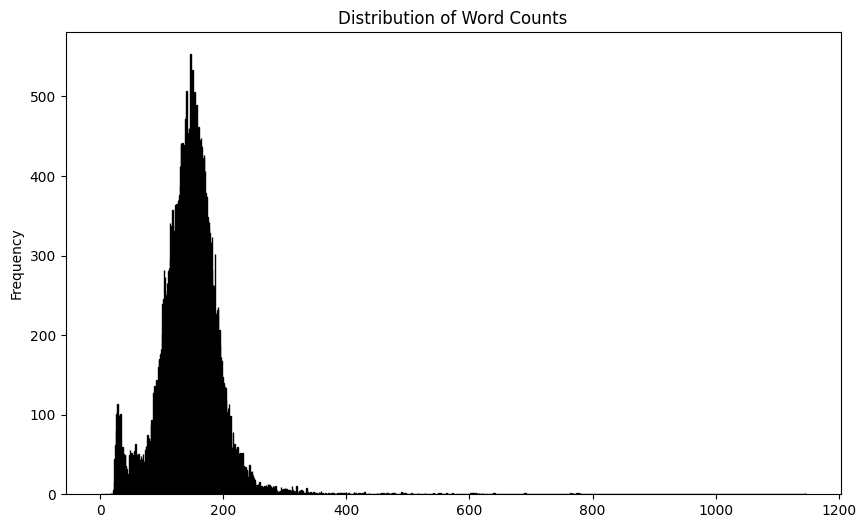

In [55]:
data['word_count'].plot(kind='hist', bins=range(1, data['word_count'].max() + 2), edgecolor='black', figsize=(10, 6), title='Distribution of Word Counts')

### Generate embeddings and save them

In [56]:
embeddings = get_embeddings(data["condensed_description"].to_list())

In [57]:
data.columns

Index(['styleType', 'discountedPrice', 'myntraRating', 'colour2',
       'materials_care_desc', 'variantName', 'articleAttributes', 'style_note',
       'productDisplayName', 'subCategory', 'size_fit_desc', 'season',
       'description', 'baseColour', 'usage', 'colour1', 'price', 'gender',
       'visualTag', 'masterCategory', 'year', 'weight', 'brandName',
       'ageGroup', 'articleType', 'id', 'fashionType', 'condensed_description',
       'word_count'],
      dtype='object')

In [58]:
raw_data = None

In [62]:
embeddings.shape

(44424, 768)

In [59]:
def store_embeddings(
    embeddings: np.ndarray, 
    path: str,
    df_full_data: pd.DataFrame, 
    number_of_trees: int = 10
) -> None:
    embedding_size = embeddings.shape[1]

    ann = AnnoyIndex(embedding_size, metric="angular")

    for idx, item_vector in enumerate(embeddings):
        id_item = df_full_data.iloc[idx]['id']
        ann.add_item(id_item, item_vector)

    ann.build(number_of_trees)
    ann.save(str(path))

In [60]:
embeddings_path = "assets/clothes-embeddings-2.ann"
store_embeddings(embeddings, path=embeddings_path, df_full_data=data)

## Test load embeddings

In [63]:
from annoy import AnnoyIndex

embedding_size = 768

ann = AnnoyIndex(embedding_size, "angular")
ann.load(embeddings_path)

similar_clothes = ann.get_nns_by_vector(get_embeddings(["a white shirt"][0]), 5)

In [64]:
similar_clothes

[2853, 5834, 29343, 3345, 36314]

In [71]:
for idx, row in data[data["id"].isin(similar_clothes)].iterrows():
    print(idx)
    print(row["description"])

2038
  Composition   White round neck T-shirt made of 100% cotton, has a ribbed round neckline with tape detailing on the in-seam, short sleeves, brand tag on the left sleeve and graphic print on the front     Fit   Slim     Wash care   Machine wash in cold water with like colours using a mild detergent  Do not bleach  Line dry inside out in shade  Warm iron: do not iron on decorations    Update your casual style with this white T-shirt from probase. The graphic print gives this tee a stylish edge while the soft cotton fabric keeps you comfortable all day. Team this with jeans and sneakers for a cool look.     Model statistics   The product is a size M on a model of height 6' and shoulders 18&rdquo; 
25323
  Composition  White round neck short sleeved t-shirt made of 100% organic cotton, with white fabric tape on the inseam of the neckline, graphic print and lettering on the front with brand name, and brand name and logo on the back of the neck   Fitting  Regular   Wash care  
 
 Gentl